# FcaBmf running over Belohlavek Dataset Demo

Copyright 2022 Bernardo C. Rodrigues

This program is free software: you can redistribute it and/or modify it under the terms of the GNU General Public
License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later
version. This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the
implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more
details. You should have received a copy of the GNU General Public License along with this program. If not, 
see <https://www.gnu.org/licenses/>. 

In [18]:
import numpy as np
from surprise import Dataset
from lib.BooleanMatrixBasedRecomenders import FcaBmf,cosine_distance

from rich.jupyter import print

In [19]:
# Get the trainset
from tests.ToyDatasets import belohlavek_dataset_raw_rating, convert_raw_rating_list_into_trainset
trainset = convert_raw_rating_list_into_trainset(belohlavek_dataset_raw_rating, shuffle=False)

In [20]:
algo = FcaBmf(coverage=1, distance_strategy=cosine_distance, verbose=True)
algo.fit(trainset)

[FcaBmf] Generating binary dataset...
[FcaBmf] Generating binary dataset OK!
[FcaBmf] Resulting binary dataset is 5 rows x 6 columns
[FcaBmf] Generating Formal Context...
[FcaBmf] Generating Formal Context OK
[FcaBmf] Generating Similarity Matrix...
[FcaBmf] Generating Similarity Matrix Ok


In [21]:
# Access to formal context
# Note that this concepts are using the internal Trainset representations
print(algo.number_of_factors)
print(algo.formal_context)

4

[
    Concept(extent=[0, 2], intent=[0, 2, 3]),
    Concept(extent=[2, 4], intent=[3, 4, 5]),
    Concept(extent=[0, 1, 3, 4], intent=[1]),
    Concept(extent=[0, 2, 3, 4], intent=[3])
]

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Let's collect some concept characteristics
intent_sizes = []
extent_sizes = []
concept_sizes = []


for formal_concept in algo.formal_context:

    formal_concept_intent_size = len(formal_concept.intent)
    formal_concept_extent_size = len(formal_concept.extent)
 
    intent_sizes.append(formal_concept_intent_size)
    extent_sizes.append(formal_concept_extent_size)

    concept_sizes.append(formal_concept_intent_size * formal_concept_extent_size)

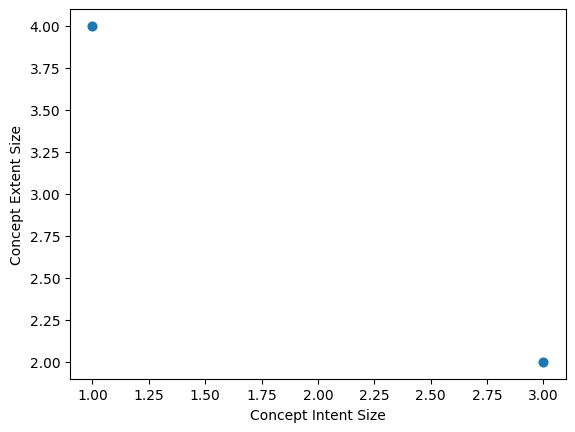

In [23]:
plt.scatter(intent_sizes, extent_sizes, alpha=1)

plt.xlabel("Concept Intent Size")
plt.ylabel("Concept Extent Size")
plt.show()

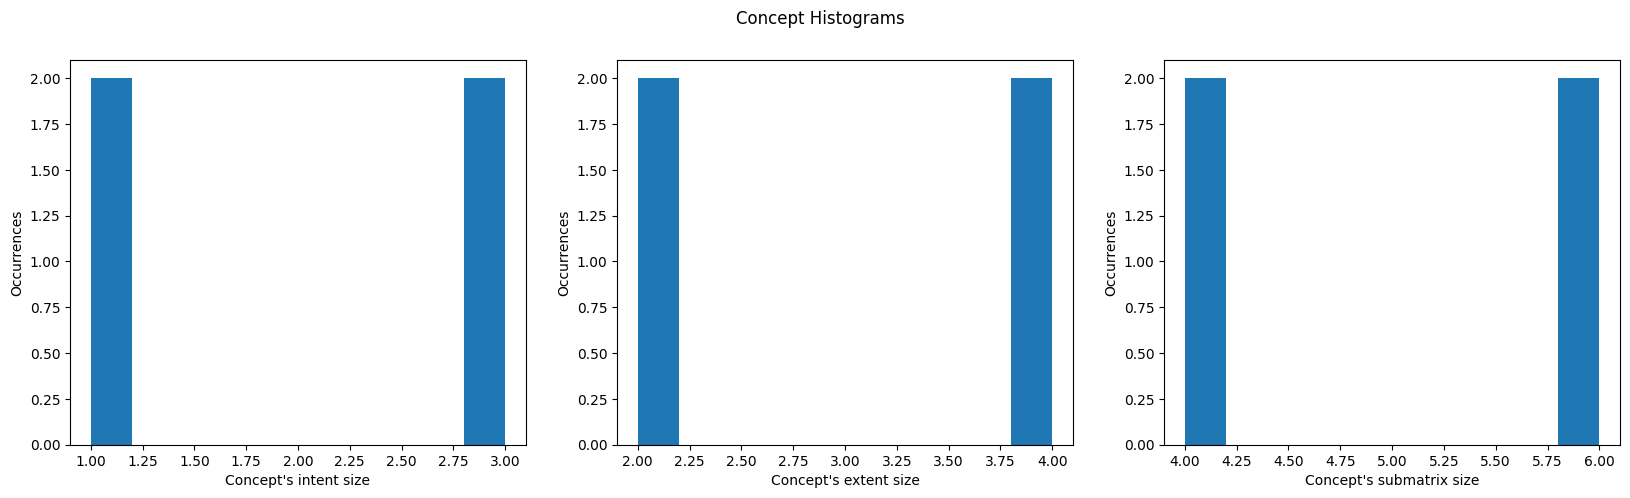

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Concept Histograms')

axs[0].hist(intent_sizes)
axs[0].set(xlabel='Concept\'s intent size', ylabel='Occurrences')

axs[1].hist(extent_sizes)
axs[1].set(xlabel='Concept\'s extent size', ylabel='Occurrences')

axs[2].hist(concept_sizes)
axs[2].set(xlabel='Concept\'s submatrix size', ylabel='Occurrences')

fig.show()


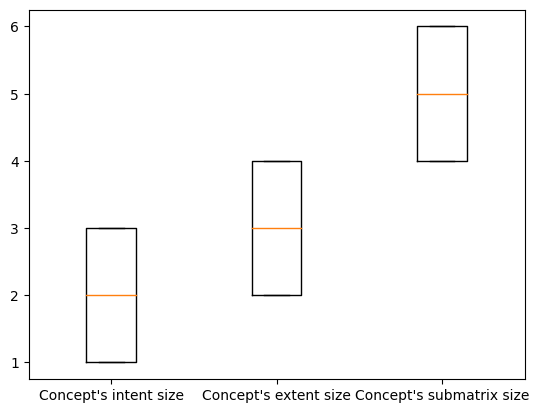

In [25]:
plt.boxplot([intent_sizes, extent_sizes, concept_sizes],
            labels=['Concept\'s intent size', 'Concept\'s extent size', 'Concept\'s submatrix size'])
plt.show()

In [26]:
# Access to factored matrices
print(algo.Af)
print(algo.Af.shape)

print(algo.Bf)
print(algo.Bf.shape)

[[ True False  True  True]
 [False False  True False]
 [ True  True False  True]
 [False False  True  True]
 [False  True  True  True]]

(5, 4)

[[ True False  True  True False False]
 [False False False  True  True  True]
 [False  True False False False False]
 [False False False  True False False]]

(4, 6)

In [27]:
# Access to similarity matrix
print(algo.sim)
print(algo.sim.shape)

[[1.         0.57735027 0.66666667 0.81649658 0.66666667]
 [0.57735027 1.         0.         0.70710678 0.57735027]
 [0.66666667 0.         1.         0.40824829 0.66666667]
 [0.81649658 0.70710678 0.40824829 1.         0.81649658]
 [0.66666667 0.57735027 0.66666667 0.81649658 1.        ]]

(5, 5)

In [28]:
# Generate similarity matrix from a vanilla KNN for comparison 
from surprise.prediction_algorithms import KNNBasic
knn_algo = KNNBasic(sim_options={"name": "cosine"})
knn_algo.fit(trainset)

print(knn_algo.sim)
print(knn_algo.sim.shape)


Computing the cosine similarity matrix...
Done computing similarity matrix.


[[1. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1.]
 [1. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]

(5, 5)

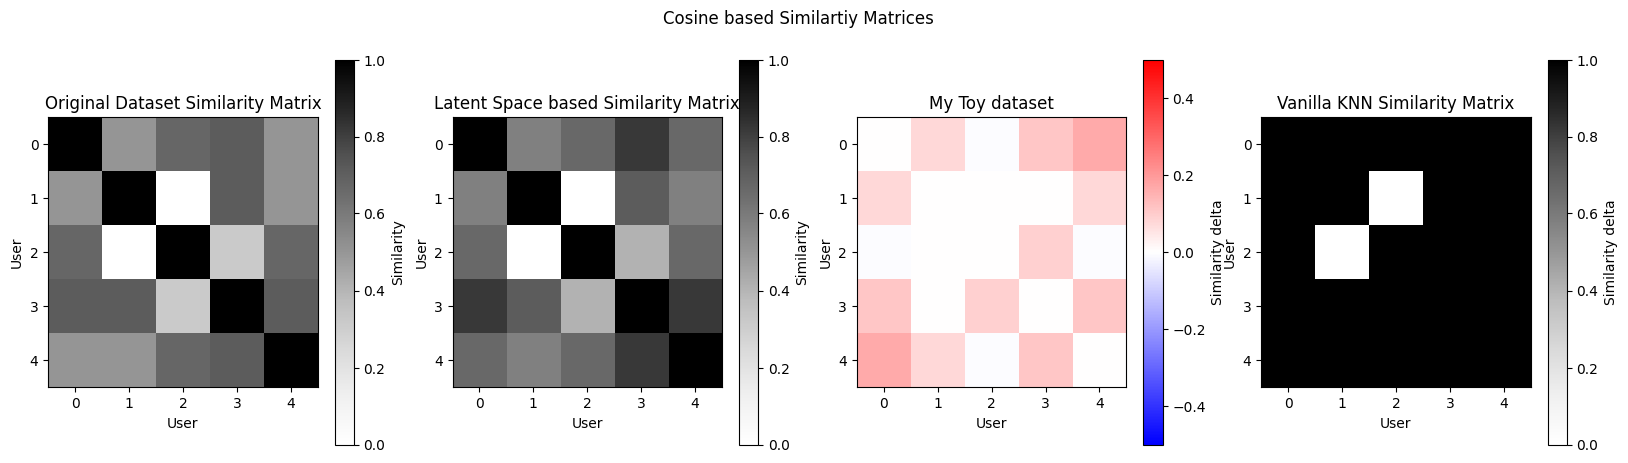

In [29]:
from lib.BooleanMatrixBasedRecomenders import get_similarity_matrix, cosine_distance

from tests.ToyDatasets import belohlavek_binary_dataset

similarity_matrix_on_original_dataset = get_similarity_matrix(algo.binary_dataset, cosine_distance)
similarity_delta = algo.sim - similarity_matrix_on_original_dataset

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('Cosine based Similartiy Matrices')

subfig = axs[0].imshow(similarity_matrix_on_original_dataset, vmin=0, vmax=1, cmap='Greys')
axs[0].set(xlabel='User', ylabel='User', title='Original Dataset Similarity Matrix')
fig.colorbar(subfig, ax=axs[1]).set_label('Similarity')

subfig = axs[1].imshow(algo.sim, vmin=0, vmax=1, cmap='Greys')
axs[1].set(xlabel='User', ylabel='User', title='Latent Space based Similarity Matrix')
fig.colorbar(subfig, ax=axs[0]).set_label('Similarity')

subfig = axs[2].imshow(similarity_delta, cmap='bwr', vmin=-0.5, vmax=0.5)
axs[2].set(xlabel='User', ylabel='User', title='My Toy dataset')
fig.colorbar(subfig, ax=axs[2]).set_label('Similarity delta')

subfig = axs[3].imshow(knn_algo.sim, cmap='Greys', vmin=0, vmax=1)
axs[3].set(xlabel='User', ylabel='User', title='Vanilla KNN Similarity Matrix')
fig.colorbar(subfig, ax=axs[3]).set_label('Similarity delta')

fig.show()

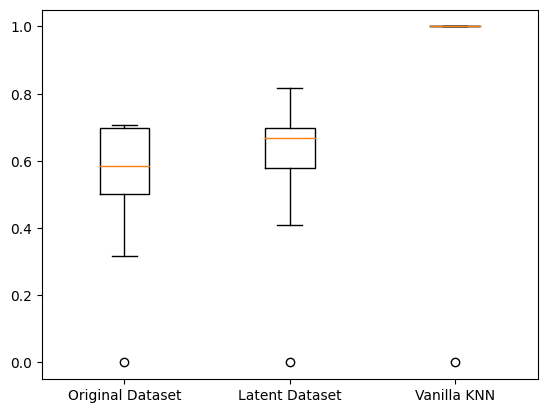

In [30]:
def flatten_similarity_matrix(matrix):
    similarities = []
    for i, _ in enumerate(matrix):
        for j, _ in enumerate(matrix):
            if i <= j:
                continue
            similarities.append(matrix[i,j])
    return similarities

original_dataset_similarities = flatten_similarity_matrix(similarity_matrix_on_original_dataset)
latent_dataset_similarities = flatten_similarity_matrix(algo.sim)
knn_similarities = flatten_similarity_matrix(knn_algo.sim)

plt.boxplot([original_dataset_similarities, latent_dataset_similarities, knn_similarities], labels=['Original Dataset', 'Latent Dataset', 'Vanilla KNN'])
plt.show()


In [31]:
# Assert that factorization covers 100% of the original matrix
I = np.matmul(algo.Af, algo.Bf)
assert (I == algo.binary_dataset._binary_dataset).all()

In [32]:
# Generate some predictions
testset = trainset.build_testset()
predictions = algo.test(testset)

In [33]:
# Overall quality of the predictions
from surprise.accuracy import mae, rmse

mae(predictions=predictions)
rmse(predictions=predictions)

MAE:  0.0000
RMSE: 0.0000


0.0

In [34]:
for prediction in predictions[:10]:
    print(prediction)

Prediction(
    uid=0,
    iid=0,
    r_ui=5.0,
    est=5,
    details={
        'actual_k': 2,
        'neighbors_used': [(0, 1.0, 5.0), (2, 0.6666666666666666, 5.0)],
        'was_impossible': False
    }
)

Prediction(
    uid=0,
    iid=2,
    r_ui=5.0,
    est=5,
    details={
        'actual_k': 4,
        'neighbors_used': [
            (0, 1.0, 5.0),
            (3, 0.8164965809277261, 5.0),
            (4, 0.6666666666666666, 5.0),
            (1, 0.5773502691896258, 5.0)
        ],
        'was_impossible': False
    }
)

Prediction(
    uid=0,
    iid=4,
    r_ui=5.0,
    est=5,
    details={
        'actual_k': 2,
        'neighbors_used': [(0, 1.0, 5.0), (2, 0.6666666666666666, 5.0)],
        'was_impossible': False
    }
)

Prediction(
    uid=0,
    iid=5,
    r_ui=5.0,
    est=5,
    details={
        'actual_k': 4,
        'neighbors_used': [
            (0, 1.0, 5.0),
            (3, 0.8164965809277261, 5.0),
            (2, 0.6666666666666666, 5.0),
            (4, 0.6666666666666666, 5.0)
        ],
        'was_impossible': False
    }
)

Prediction(
    uid=1,
    iid=2,
    r_ui=5.0,
    est=5,
    details={
        'actual_k': 4,
        'neighbors_used': [
            (1, 1.0, 5.0),
            (3, 0.7071067811865475, 5.0),
            (0, 0.5773502691896258, 5.0),
            (4, 0.5773502691896258, 5.0)
        ],
        'was_impossible': False
    }
)

Prediction(
    uid=2,
    iid=0,
    r_ui=5.0,
    est=5,
    details={
        'actual_k': 2,
        'neighbors_used': [(2, 1.0, 5.0), (0, 0.6666666666666666, 5.0)],
        'was_impossible': False
    }
)

Prediction(
    uid=2,
    iid=1,
    r_ui=5.0,
    est=5,
    details={
        'actual_k': 2,
        'neighbors_used': [(2, 1.0, 5.0), (4, 0.6666666666666666, 5.0)],
        'was_impossible': False
    }
)

Prediction(
    uid=2,
    iid=3,
    r_ui=5.0,
    est=5,
    details={
        'actual_k': 2,
        'neighbors_used': [(2, 1.0, 5.0), (4, 0.6666666666666666, 5.0)],
        'was_impossible': False
    }
)

Prediction(
    uid=2,
    iid=4,
    r_ui=5.0,
    est=5,
    details={
        'actual_k': 2,
        'neighbors_used': [(2, 1.0, 5.0), (0, 0.6666666666666666, 5.0)],
        'was_impossible': False
    }
)

Prediction(
    uid=2,
    iid=5,
    r_ui=5.0,
    est=5,
    details={
        'actual_k': 4,
        'neighbors_used': [
            (2, 1.0, 5.0),
            (0, 0.6666666666666666, 5.0),
            (4, 0.6666666666666666, 5.0),
            (3, 0.40824829046386313, 5.0)
        ],
        'was_impossible': False
    }
)